# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings('ignore')

## Подготовка данных

### Прелюдии

In [2]:
# открываем файл
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# смотрим на общую информацию, привет пропускам
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Сразу можно отметить пустоты в значениях
<br>А так же нужно преобразовать типы данных
<br>И изменить название признаков**

In [4]:
# смотрим на распределение, аномалиям тоже привет
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Начнем с изменения названий фичей

In [5]:
# понизим в нижний регистр названия и разделим слова camel_case
df = df.rename(columns={'DateCrawled':'Date_Crawled', 
                        'VehicleType':'Vehicle_Type',
                        'RegistrationYear':'Registration_Year', 
                        'RegistrationMonth':'Registration_Month', 
                        'FuelType':'Fuel_Type', 
                        'DateCreated':'Date_Created',
                        'NumberOfPictures':'Number_Of_Pictures',
                        'PostalCode':'Postal_Code',
                        'LastSeen':'Last_Seen'})
df.columns = df.columns.str.lower()
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Рассмотрим признаки

In [6]:
# Заведём множества для категоризации признаков
drop_features = set()
categorical_features = set()
numeric_features = set()

**date_crawled**

In [7]:
col = 'date_crawled'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']


In [8]:
# Вывод: эту колонку можно выбросить из обучения, это просто дата загрузки 
drop_features.add(col)

**price**

In [9]:
col = 'price'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [  480 18300  9800 ... 12395 18429 10985]


In [10]:
# Вывод - признак численный
numeric_features.add(col)

**vehicle_type**

In [11]:
col = 'vehicle_type'
unique = df[col].unique()
count = df[col].value_counts()
print('Все категории:', unique)
print(count)

Все категории: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64


In [12]:
# Вывод - это категориальный признак
categorical_features.add(col)

**registration_year**

In [13]:
# не до конца понял, это регистрация в ГАИ или регистрация на заводе. Просто регистрация в ГАИ для цены смысловой
# нагрузки не имеет, но оставим, потому что я не уверен
col = 'registration_year'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


In [14]:
# Вывод - признак численный
numeric_features.add(col)

**gearbox**

In [15]:
col = 'gearbox'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['manual' 'auto' nan]


In [16]:
# Вывод - это категориальный признак
categorical_features.add(col)

**power**

In [17]:
col = 'power'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231    90   118   193    99   113   218
   122   129    70   306    95    61   177    80   170    55   143    64
   286   232   150   156    82   155    54   185    87   180    86    84
   224   235   200   178   265    77   110   144   120   116   184   126
   204    88   194   305   197   179   250    45   313    41   165    98
   130   114   211    56   201   213    58   107    83   174   100   220
    85    73   192    68    66   299    74    52   147    65   310    71
    97   239   203     5   300   103   258   320    63    81   148    44
   145   230   280   260   104   188   333   186   117   141    59   132
   234   158    39    92    51   135    53   209    43   146    67   106
   166   276   344    72   249   237   245   111   326   279    23   138
   175    96   226    26    37   301   334   128   133   124    33   219
   241   167    94   182   196   238

In [18]:
# Вывод - признак численный
numeric_features.add(col)

**model**

In [19]:
col = 'model'
unique = df[col].sort_values().unique()
print('Все категории:', unique)
count = df[col].value_counts()
print(count[200:])

Все категории: ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiz

In [20]:
# Вывод - это категориальный признак
categorical_features.add(col)

**kilometer**

In [21]:
col = 'kilometer'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [150000 125000  90000  40000  30000  70000   5000 100000  60000  20000
  80000  50000  10000]


In [22]:
# Вывод - признак численный
numeric_features.add(col)

**registration_month**

In [23]:
col = 'registration_month'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [ 0  5  8  6  7 10 12 11  2  3  1  4  9]


In [24]:
# Вывод: эту колонку можно выбросить из обучения, помогло бы, если бы исследовали количество продаж
drop_features.add(col)

**fuel_type**

In [25]:
col = 'fuel_type'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [26]:
# Вывод - это категориальный признак
categorical_features.add(col)

**brand**

In [27]:
col = 'brand'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


In [28]:
# Вывод - это категориальный признак
categorical_features.add(col)

**repaired**

In [29]:
col = 'repaired'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [nan 'yes' 'no']


In [30]:
# Вывод - это категориальный признак
categorical_features.add(col)

**date_created**

In [31]:
col = 'date_created'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['2016-03-24 00:00:00' '2016-03-14 00:00:00' '2016-03-17 00:00:00'
 '2016-03-31 00:00:00' '2016-04-04 00:00:00' '2016-04-01 00:00:00'
 '2016-03-21 00:00:00' '2016-03-26 00:00:00' '2016-04-07 00:00:00'
 '2016-03-15 00:00:00' '2016-03-11 00:00:00' '2016-03-20 00:00:00'
 '2016-03-23 00:00:00' '2016-03-27 00:00:00' '2016-03-12 00:00:00'
 '2016-03-13 00:00:00' '2016-03-18 00:00:00' '2016-03-10 00:00:00'
 '2016-03-07 00:00:00' '2016-03-09 00:00:00' '2016-03-08 00:00:00'
 '2016-04-03 00:00:00' '2016-03-29 00:00:00' '2016-03-25 00:00:00'
 '2016-03-28 00:00:00' '2016-03-30 00:00:00' '2016-03-22 00:00:00'
 '2016-02-09 00:00:00' '2016-03-05 00:00:00' '2016-04-02 00:00:00'
 '2016-03-16 00:00:00' '2016-03-19 00:00:00' '2016-04-05 00:00:00'
 '2016-03-06 00:00:00' '2016-02-12 00:00:00' '2016-03-03 00:00:00'
 '2016-03-01 00:00:00' '2016-03-04 00:00:00' '2016-04-06 00:00:00'
 '2016-02-15 00:00:00' '2016-02-24 00:00:00' '2016-02-27 00:00:00'
 '2015-03-20 00:00:00' '2016-02-28 00:00:00' '2

In [32]:
# Вывод: эту колонку можно выбросить из обучения, дата создания объявления, нам не поможет предсказать цену
drop_features.add(col)

**number_of_pictures**

In [33]:
col = 'number_of_pictures'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [0]


In [34]:
# Вывод: эту колонку можно выбросить из обучения, не несет смысловой нагрузки
drop_features.add(col)

**postal_code**

In [35]:
col = 'postal_code'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: [70435 66954 90480 ... 38528 38325 31096]


In [36]:
# Вывод: эту колонку можно выбросить из обучения, не несет смысловой нагрузки
drop_features.add(col)

**last_seen**

In [37]:
col = 'last_seen'
unique = df[col].unique()
print('Все категории:', unique)

Все категории: ['2016-04-07 03:16:57' '2016-04-07 01:46:50' '2016-04-05 12:47:46' ...
 '2016-03-19 20:44:43' '2016-03-29 10:17:23' '2016-03-21 10:42:49']


In [38]:
# Вывод: эту колонку можно выбросить из обучения, не несет смысловой нагрузки
drop_features.add(col)

### Причешем

In [39]:
# удалим ненужные колонки
df = df.drop(columns=drop_features)

In [42]:
# посмотрим на неявные дубликаты
for _ in df[list(categorical_features)]:
    print(f'{_}:\n{df[_].sort_values().unique()}')
    print('~'*75)

fuel_type:
['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
model:
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focu

In [43]:
# замечаем марка + модель, только у ренжа
df['model'] = df['model'].str.replace('rangerover','range_rover')

### Что с пропусками

In [44]:
df.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

**model**

In [45]:
# с моделью ничего особо не сделаешь, посмотрим, сколько пропадеть
df.model.isna().sum() * 100 / df.__len__()

5.560587974681758

In [46]:
# больше чем хотелось бы, на процентик бы меньше, но придется избавиться
df = df.dropna(subset=['model'])

**gearbox**

In [47]:
# с коробкой тоже самое, посмотрим, сколько пропадет, недостаточно информации, что бы изменить
df.gearbox.isna().sum() * 100 / df.__len__()

4.6918700547414725

In [48]:
# придется избавиться
df = df.dropna(subset=['gearbox'])

**fuel_type**

In [49]:
# с топливом не лучше, посмотрим, сколько пропадет, недостаточно информации, что бы изменить
df.fuel_type.isna().sum() * 100 / df.__len__()

6.186943899273268

In [50]:
# придется избавиться
df = df.dropna(subset=['fuel_type'])

**repaired**

In [51]:
# тут могли умолчать, поэтому создадим заглушку unknown

In [52]:
df['repaired'] = df['repaired'].fillna('unknown')

**vehicle_type**

In [53]:
# самое веселое, попробуем относительно других моделей

In [54]:
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('model')['vehicle_type'].transform(lambda x: x.value_counts().idxmax())                                        )

### Настало время аномалиям

**price**

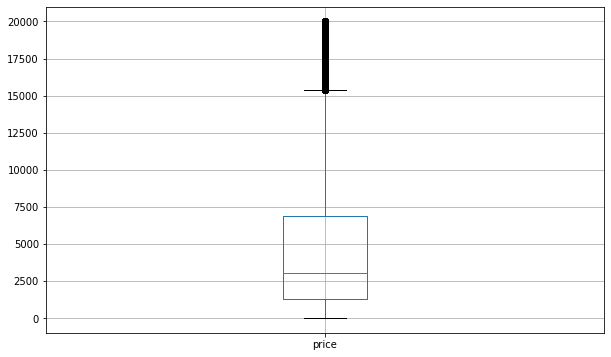

In [55]:
df.boxplot('price', figsize=(10,6));

In [56]:
# очень сильно смущают авто стоимостью меньше 100 евро? избавимся от них
df = df[df['price']>100]
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


**registration_year**

In [57]:
# для начала, есть конечно непонятки с датами выше 16го года, может конечно я что-то не понял, 
# но избавимся до создания авто и от нынешнего года
df = df[(df['registration_year'] < 2017) & (df['registration_year'] > 1900)]

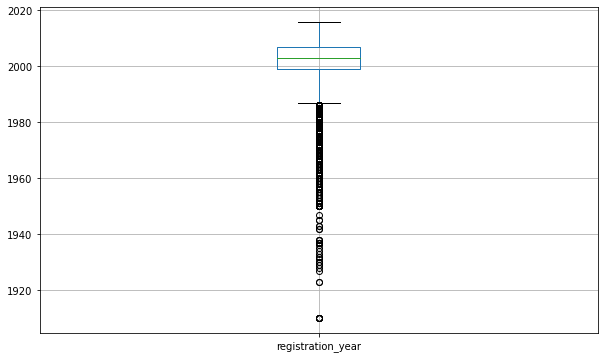

In [58]:
df.boxplot('registration_year', figsize=(10,6));

**power**

In [59]:
# уберем мощные авто
df = df[(df['power'] < 1000) & (df['power'] > 0)]

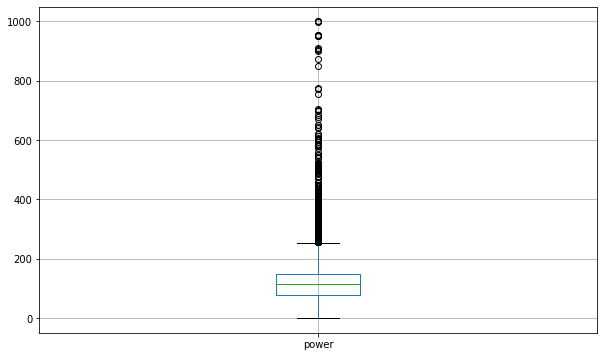

In [60]:
df.boxplot('power', figsize=(10,6));

**kilometer**

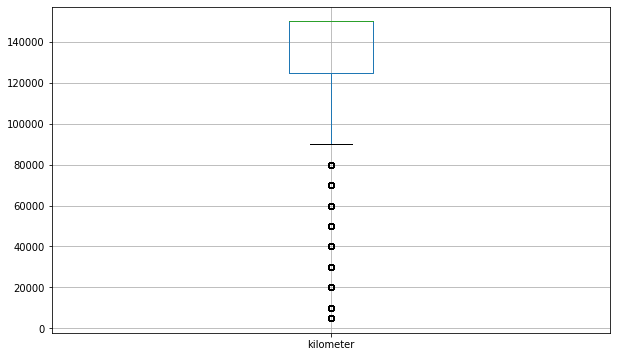

In [61]:
# тут в целом неплохо
df.boxplot('kilometer', figsize=(10,6));

### Играем с данными

In [63]:
# выделим целевую переменную
X = df.loc[:,'vehicle_type':]
y = df['price']

In [65]:
# разобьем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

In [66]:
# кодируем
categorical_features = list(categorical_features)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train[categorical_features])
X_train[categorical_features] = ordinal_encoder.transform(X_train[categorical_features])
X_test[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])

In [67]:
# масштабируем
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index, dtype='float32')
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index, dtype='float32')

**В целом, данные имеют теперь причесанный вид, избавились от пустот, аномалий и не нужных признаков, а так же дубликатов. 
<br>Привели всё к числу (единственное, я не понял, у меня сейчас скаллер на всём датафрейме обучен, потому что в тесте есть непересекающиеся и тест не масштабируется)**

## Обучение моделей

In [71]:
param_grid = {
      'n_estimators': range(1,101),
      'max_depth': range(1,11)}
kf = KFold(n_splits=2)

### LGBMRegressor

In [72]:
%%time
estimator = LGBMRegressor(random_state=12345)
model_lgbm = RandomizedSearchCV(estimator, 
                     param_grid,
                     verbose = False,
                     scoring = 'neg_mean_squared_error')
model_lgbm.fit(X_train, y_train)
b_p_lgbm = model_lgbm.best_params_

CPU times: user 1min 13s, sys: 1.23 s, total: 1min 14s
Wall time: 1min 15s


In [73]:
%%time
model_lgbm = LGBMRegressor(n_estimators = b_p_lgbm['n_estimators'], 
                           max_depth = b_p_lgbm['max_depth'], 
                           random_state=12345)
model_lgbm.fit(X_train, y_train)

CPU times: user 2.87 s, sys: 49.1 ms, total: 2.92 s
Wall time: 2.9 s


LGBMRegressor(max_depth=7, n_estimators=96, random_state=12345)

In [74]:
%%time
preds_model_lgbm = model_lgbm.predict(X_train)

CPU times: user 1.08 s, sys: 43.7 ms, total: 1.13 s
Wall time: 1.2 s


In [76]:
mse_model_lgbm = mean_squared_error(y_train, preds_model_lgbm)
print("RMSE для  LightGBM на тестовой выборке:", (mse_model_lgbm) ** 0.5, 2)

RMSE для  LightGBM на тестовой выборке: 1638.0776326941232 2


### XGBRegressor

In [77]:
%%time
estimator = XGBRegressor(random_state=12345)
model_xgbr = RandomizedSearchCV(estimator, 
                     param_grid,
                     verbose = False,
                     scoring='neg_mean_squared_error',
                     )
model_xgbr.fit(X_train, y_train)
b_p_xgbr = model_xgbr.best_params_

CPU times: user 9min 12s, sys: 5.87 s, total: 9min 18s
Wall time: 9min 24s


In [78]:
%%time
model_xgbr = XGBRegressor(n_estimators = b_p_xgbr['n_estimators'], 
                          max_depth = b_p_xgbr['max_depth'], 
                          random_state=12345)
model_xgbr.fit(X_train, y_train)

CPU times: user 22.5 s, sys: 190 ms, total: 22.7 s
Wall time: 22.9 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=46, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
%%time
preds_model_xgbr = model_xgbr.predict(X_train)

CPU times: user 376 ms, sys: 10.2 ms, total: 386 ms
Wall time: 348 ms


In [80]:
mse_model_xgbr = mean_squared_error(y_train, preds_model_xgbr)
print("RMSE для  LightGBM на тестовой выборке:", (mse_model_xgbr) ** 0.5, 2)

RMSE для  LightGBM на тестовой выборке: 1307.5053435605553 2


### CatBoostRegressor

In [81]:
%%time
estimator = CatBoostRegressor(random_state=12345, verbose = False)
model_cbr = RandomizedSearchCV(estimator, 
                     param_grid,
                     verbose = False,
                     scoring='neg_mean_squared_error',
                     )
model_cbr.fit(X_train, y_train)
b_p_cbr = model_cbr.best_params_

CPU times: user 44.6 s, sys: 367 ms, total: 45 s
Wall time: 1min 5s


In [82]:
%%time
model_cbr = CatBoostRegressor(n_estimators = b_p_cbr['n_estimators'], 
                              max_depth = b_p_cbr['max_depth'], 
                              random_state=12345, 
                              verbose = False)
model_cbr.fit(X_train, y_train)

CPU times: user 1.94 s, sys: 5.75 ms, total: 1.94 s
Wall time: 2.29 s


In [83]:
%%time
preds_model_cbr = model_cbr.predict(X_train)

CPU times: user 46.1 ms, sys: 63 µs, total: 46.2 ms
Wall time: 44.8 ms


In [84]:
mse_model_cbr = mean_squared_error(y_train, preds_model_cbr)
print("RMSE для  LightGBM на тестовой выборке:", (mse_model_cbr) ** 0.5, 2)

RMSE для  LightGBM на тестовой выборке: 1503.0898692071278 2


### RandomForestRegressor

In [85]:
%%time
estimator = RandomForestRegressor(random_state=12345)
model_rfr = RandomizedSearchCV(estimator, 
                     param_grid,
                     verbose = False,
                     scoring='neg_mean_squared_error',
                     )
model_rfr.fit(X_train, y_train)
b_p_rfr = model_rfr.best_params_

CPU times: user 4min 24s, sys: 640 ms, total: 4min 24s
Wall time: 4min 24s


In [86]:
%%time
model_rfr = RandomForestRegressor(n_estimators = b_p_rfr['n_estimators'], 
                                  max_depth = b_p_rfr['max_depth'], 
                                  random_state=12345)
model_rfr.fit(X_train, y_train)

CPU times: user 17.9 s, sys: 66.7 ms, total: 18 s
Wall time: 18 s


RandomForestRegressor(max_depth=10, n_estimators=98, random_state=12345)

In [87]:
%%time
preds_model_rfr = model_rfr.predict(X_train)

CPU times: user 1.23 s, sys: 694 µs, total: 1.23 s
Wall time: 1.24 s


In [88]:
mse_model_rfr = mean_squared_error(y_train, preds_model_rfr)
print("RMSE для  LightGBM на тестовой выборке:", (mse_model_rfr) ** 0.5, 2)

RMSE для  LightGBM на тестовой выборке: 1758.2995607624134 2


In [91]:
time_f = ["2.9 s", '22.9 s', '2.29 s', '18 s']
time_p = ['1.2 s', '348 ms', '44.8 ms', '1.24 s']
pred_r = [mse_model_lgbm** 0.5, mse_model_xgbr** 0.5, mse_model_cbr** 0.5, mse_model_rfr** 0.5]
data = pd.DataFrame({'t_fit':time_f, 't_pred':time_p, 'rmse_pred':pred_r}, 
                    index=['LGBMRegressor', 'XGBRegressor', 'CatBoostRegressor', 'RandomForestRegressor'])
data

,t_fit,t_pred,rmse_pred
LGBMRegressor,2.9 s,1.2 s,1638.077633
XGBRegressor,22.9 s,348 ms,1307.505344
CatBoostRegressor,2.29 s,44.8 ms,1622.081623
RandomForestRegressor,18 s,1.24 s,1758.299561


**Нами протестированно 4 модели:
<br> 1)LGBMRegressor
<br> 2)XGBRegressor
<br> 3)CatBoostRegressor
<br> 4)RandomForestRegressor
<br> В целом модели, кроме LGBMRegressor, с небольшим набором перебора гиперпараметров обучаются быстро
<br>Перебор гиперпараметров осуществлялся с помощью RandomizedSearchCV.**

## Анализ моделей

**Перебрав гиперпараметры:
<br>Наилучшей моделью оказалась по точности XGBRegressor : 1307.50, но самая медленная скорость обучения	
<br>По скорости обучения и предсказаний лучшая модель оказалась CatBoostRegressor : 2.29 s и 44.8 ms
<br>И поскольку, по ТЗ точность по RMSE должна быть ниже 2,5к, то с учетом этого, мой выбор падает на catboost (тем более, что по точности обучения, он на втором месте 1622.08 и второй по скорости обучения и предсказания)**

In [89]:
%%time
preds_model_cbr = model_cbr.predict(X_test)

CPU times: user 35.2 ms, sys: 13 µs, total: 35.2 ms
Wall time: 34.6 ms


In [90]:
mse_model_cbr = mean_squared_error(y_test, preds_model_cbr)
print("RMSE для  LightGBM на тестовой выборке:", (mse_model_cbr) ** 0.5, 2)

RMSE для  LightGBM на тестовой выборке: 1622.081622587514 2


**Вот и результат для нашего заказчика. Менее точно, зато гораздо быстрее.**

## Вывод

**В ходе работы были выполнены следующие действия:
<br>1) Подгружен датасет, который пришлось причесать от путых значений, аномалий, дубликатов и в целом от ненужных нам признаков
<br>2) Далее подобрав средние гиперпараметры для всех моделей обучил их с замером времени
<br>3) По ТЗ нам требовалось не ниже 2.5 RMSE, с этим справилось 4/4 моделей
<br>4) Исходя из времени обучения и предсказаний и достаточно хорошего RMSE, подходящая под ТХ, была выбрана именно эта модель**